In [1]:
import time
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.io import ascii
import numpy as np
from Corrfunc.theory import DDsmu
from Corrfunc.theory.DD import DD
import os


In [2]:
path =  '/global/cscratch1/sd/jiaxi/master/catalog/0211_LRG_real/'
lrgcat = Table.read(path+'LRGorg.dat',format="ascii",data_start=1)
X,Y,Z = lrgcat['x'],lrgcat['y'],lrgcat['z']
boxsize = 2500
nthreads = 64
nbins = 100
rmax =200
nmu =120
mu_max = 1
LRGnum=len(X)
autocorr=1

In [3]:
# RR calculation
bins = np.linspace(0, rmax, nbins + 1) 
s = (bins[1:]+bins[:-1])/2
mu_tot = np.linspace(0,mu_max,nmu+1)
mu = (mu_tot[1:]+mu_tot[:-1])/2
theta_tot = np.arccos(mu_tot)
# calculate the expression in d\theta and d\mu to see the difference 
dtheta = (theta_tot[:-1]-theta_tot[1:])
dthetamu = 1/nmu/np.sqrt(1-mu**2)

RR_counts= 4*np.pi/3*(bins[1:]**3-bins[:-1]**3)/(boxsize**3)
rr=RR_counts.reshape(nbins,1)+np.zeros((1,nmu))

rr1= rr*dtheta*2/np.pi
rr2 = rr*dthetamu*2/np.pi

In [4]:
DD_smu = DDsmu(autocorr, nthreads, bins,mu_max, nmu, X, Y, Z,periodic=True, verbose=True,boxsize=boxsize)
#DD_smu['npairs'][0] -=LRGnum
#DD_s = DD(autocorr, nthreads, bins, X, Y, Z,periodic=True, verbose=True,boxsize=boxsize)

Running with points in [xmin,xmax] = 0.000000,2499.999756 with periodic wrapping = 2500.000000
Running with points in [ymin,ymax] = 0.000000,2499.999756 with periodic wrapping = 2500.000000
Running with points in [zmin,zmax] = 0.000400,2499.997803 with periodic wrapping = 2500.000000
In gridlink_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,25,12.  Time taken =   0.669 sec
Using AVX kernel
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 26.408 secs


In [5]:
# create a random catalogue and calculate the DDsmu
loc = np.random.uniform(0,2500,size=(LRGnum,3))
DD_smu_rand = DDsmu(autocorr, nthreads, bins,mu_max, nmu, loc[:,0], loc[:,1], loc[:,2],periodic=True, verbose=True,boxsize=boxsize)

Running with points in [xmin,xmax] = 0.000005,2499.999456 with periodic wrapping = 2500.000000
Running with points in [ymin,ymax] = 0.001021,2499.999949 with periodic wrapping = 2500.000000
Running with points in [zmin,zmax] = 0.000052,2499.999508 with periodic wrapping = 2500.000000
In gridlink_double> Running with [nmesh_x, nmesh_y, nmesh_z]  = 25,25,12.  Time taken =   0.670 sec
0%.........10%.........20%.........30%.........40%.........50%.........60%.........70%.........80%.........90%.........100% done. Time taken = 27.731 secs


In [6]:
mono_rand = DD_smu_rand['npairs'].reshape(nbins,nmu)/LRGnum**2
Table([mono_rand.flatten(),rr.flatten()],names=['sim','analy']).write('RR.dat',format='ascii',overwrite=True)

In [16]:
smin = 0
smax = 200
ns = 100
nmu = 120
sedge = np.linspace(smin, smax, ns+1)
rr1d = 4 * np.pi / 3 * (sedge[1:]**3 - sedge[:-1]**3) / 2500**3
rr3 = np.array([rr1d] * nmu).T / nmu

The normalised pair counts of the random catalogue {mono_rand} and the analytical result {rr} are stored in RR.dat. I didn't figure out the difference between the numbers row by row. However, the monopole result show that our rr calculation has done something wrong. 

In [45]:
mono = DD_smu['npairs'].reshape(nbins,nmu)/(LRGnum**2)/rr1-1
monor = DD_smu['npairs'].reshape(nbins,nmu)/(LRGnum**2)/rr*nmu-1
mono0 = DD_smu['npairs'].reshape(nbins,nmu)/(LRGnum**2)/rr2-1
mono00 = DD_smu['npairs'].reshape(nbins,nmu)/(LRGnum**2)/rr3-1
mono1 = DD_smu['npairs'].reshape(nbins,nmu)/(LRGnum**2)/mono_rand-1
xi0 = np.trapz(mono, dx=1./nmu, axis=1)
xir = np.trapz(monor, dx=1./nmu, axis=1)
xi00 = np.trapz(mono0, dx=1./nmu, axis=1)
xi000 = np.trapz(mono00, dx=1./nmu, axis=1)
xi01 = np.trapz(mono1, dx=1./nmu, axis=1)
#xi = DD_s['npairs']/(LRGnum**2)/RR_counts.reshape(nbins)-1
# test the monopole results

In [41]:
rr1d==RR_counts

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [42]:
np.all(np.array([rr1d] * nmu).T ==rr)

True

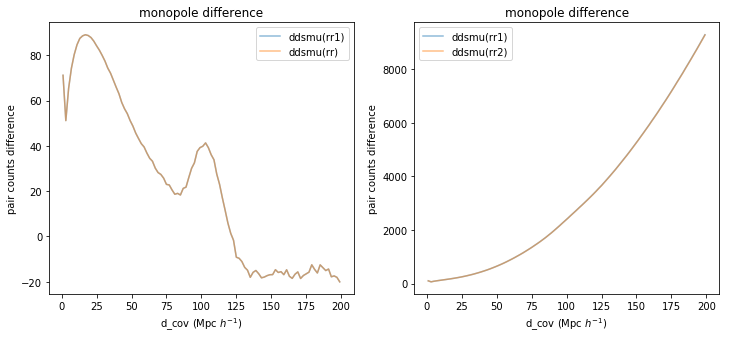

In [46]:
org = Table.read('/global/cscratch1/sd/jiaxi/master/2PCF/0211_LRG_real/LRGorg.dat',format="ascii.no_header")
fig=plt.figure(figsize=(12,5))
for i in range(2):
    ax = plt.subplot2grid((1,2),(0,i))
    #ax.plot(org['col1'],org['col1']**2*org['col2'],label='org')
    if i==0:
        #ax.plot(s,s**2*xi01,alpha=0.5,label='ddsmu(randcata)')
        ax.plot(s,s**2*xi000,alpha=0.5,label='ddsmu(rr1)')
        ax.plot(s,s**2*xir,alpha=0.5,label='ddsmu(rr)')
        plt.title('monopole difference')
    if i==1:
        ax.plot(s,s**2*xi00,alpha=0.5,label='ddsmu(rr1)')
        ax.plot(s,s**2*xi0,alpha=0.5,label='ddsmu(rr2)')
        plt.title('monopole difference')
    #ax.plot(s,s**2*xi,alpha=0.5,label='dd')
    plt.legend(loc=0)
    plt.xlabel('d_cov (Mpc $h^{-1}$)')
    #plt.yscale('log')
    plt.ylabel('pair counts difference')

Text(0.5,1,'random pair counts/analytical expression')

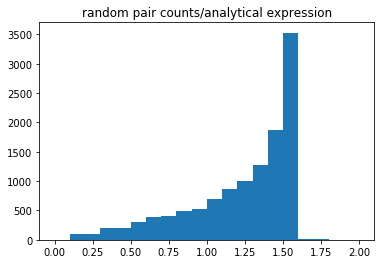

In [9]:
plt.hist(mono_rand.flatten()/rr1.flatten(),range=(0,2),bins=20)
plt.title('random pair counts/analytical expression')

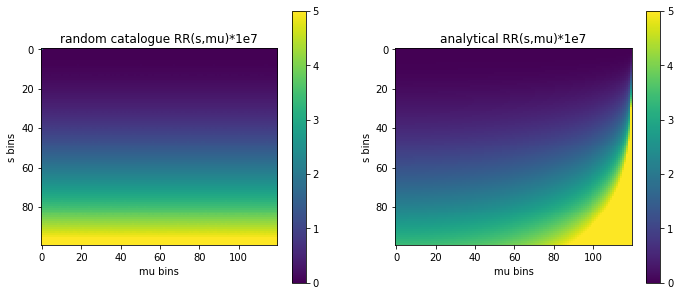

In [15]:
from matplotlib.colors import LogNorm
from matplotlib import colors
fig = plt.figure(figsize=(18,5))
for i,arr in zip(range(3),[mono_rand,rr1]):
    ax = plt.subplot2grid((1,3),(0,i),rowspan=1,colspan=1)
    plt.xlabel('mu bins')
    plt.ylabel('s bins')
    im=ax.imshow(arr*1e7,vmin=0,vmax=5)
    plt.colorbar(im,ax=ax)
    if i==0:
        plt.title('random catalogue RR(s,mu)*1e7')
    if i==1:
        plt.title('analytical RR(s,mu)*1e7')
plt.show()


In [13]:
LRGnum

5468750